In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import csv
import os
import os.path
from pathlib import Path
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from IPython.display import display
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from time import gmtime, strftime
from jupyterthemes import jtplot
import re
import gc
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from sklearn.model_selection import StratifiedShuffleSplit

from functools import partial
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from skopt import gp_minimize
from skopt import space 


# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

pd.options.display.max_columns=1000
pd.options.display.max_rows=300
pd.set_option('display.float_format', lambda x: '%.3f' % x)
gc.collect()


6

In [2]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


#Move Specified column to last
def move_to_last(df,column):
    churn=df[column]
    df_lst=df.drop([column],axis=1)
    df_lst=pd.concat([df_lst,churn],axis=1)
    return df_lst

#Computing AUC
def auc_curve(df,ytest,qtr,model_name):
    #Ploting AUC curve.
    y_pred = df['prob'].values
    ns_probs =[0 for _ in range(len(ytest))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(ytest, y_pred)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=str(model_name)+str(qtr))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    print(str(qtr)+ str(model_name)+ "ROC-AUC score is: ", (roc_auc_score(ytest, y_pred))*100)

#Computing Precision Recall Curve
def pre_rec_curve(tdf,actual,qtr):
    y_pred = tdf['prob'].values
    lr_precision, lr_recall, _ = precision_recall_curve(actual, y_pred)
    lr_auc =  auc(lr_recall, lr_precision)
    # summarize scores
    print('LightGBM '+str(qtr)+' : precision recal curve=%.3f' % ( lr_auc))
    # plot the precision-recall curves
    no_skill = len(actual[actual==4]) / len(actual)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='LighGBM '+str(qtr))
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

#Defining highest F1 Score
def f1_thershold(Pred,Actual,fold):
    Thres_list=[]
    f1_list=[]
    fold_list=[]
    for x in np.arange(.1,.9,0.005):
            y_pred=np.where(Pred>x,1,0)
            Thres_list.append(x)
            f1_list.append(f1_score(Actual,y_pred, average='macro'))
            fold_list.append(fold)
            Thres_df = pd.DataFrame(list(zip(Thres_list,f1_list,fold_list)),columns =['Threshold','F1score','fold'])
            max_f1=Thres_df.F1score.max()
            Thres_df=Thres_df[Thres_df['F1score']==max_f1]
    return(Thres_df)

#Computing Confusion Matrix
def conf_matr(tdf,actual,cut_off):
    #Confusion matrix for 21Q1
    y_pred =np.where(tdf['prob'].values>cut_off,1,0)
    print(confusion_matrix(actual,y_pred))
    #extracting true_positives, false_positives, true_negatives, false_negatives
    tn, fp, fn, tp = confusion_matrix(actual,y_pred).ravel()
    print("True Negatives: ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives: ",tp)
    print('Accuracy:' ,accuracy_score(actual,y_pred))
    print(classification_report(actual,y_pred))

In [3]:
#os.getcwd()
#Setting data directory
data_dir = Path('..','iim_apds_churn_prjct')

data_path=Path(data_dir,'data/satish/prep_telo_df.csv')
telo_df=pd.read_csv(data_path)
telo_df.head()

,Customer_ID,churn,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,blck_vce_Mean,unan_vce_Mean,plcd_dat_Mean,custcare_Mean,threeway_Mean,iwylis_vce_Mean,callwait_Mean,months,uniqsubs,actvsubs,totcalls,totrev,hnd_price,phones,truck,lor,adults,income,numbcars,eqpdays,fe_mean_per_minute_charge,fe_tot_revenue_per_call,fe_tot_mou_per_call,fe_tot_revenue_adj,fe_tot_mou_adj,HHstatin_A,HHstatin_B,HHstatin_C,HHstatin_G,HHstatin_I,HHstatin_Missing,area_ATLANTIC_SOUTH_AREA,area_CALIFORNIA_NORTH_AREA,area_CENTRAL_SOUTH_TEXAS_AREA,area_CHICAGO_AREA,area_DALLAS_AREA,area_DC_MARYLAND_VIRGINIA_AREA,area_GREAT_LAKES_AREA,area_HOUSTON_AREA,area_LOS_ANGELES_AREA,area_MIDWEST_AREA,area_NEW_ENGLAND_AREA,area_NEW_YORK_CITY_AREA,area_NORTH_FLORIDA_AREA,area_NORTHWEST_ROCKY_MOUNTAIN_AREA,area_OHIO_AREA,area_PHILADELPHIA_AREA,area_SOUTH_FLORIDA_AREA,area_SOUTHWEST_AREA,area_TENNESSEE_AREA,asl_flag_N,asl_flag_Y,crclscod_A,crclscod_AA,crclscod_B,crclscod_BA,crclscod_C,crclscod_CA,crclscod_DA,crclscod_EA,crclscod_ZA,creditcd_Missing,creditcd_N,creditcd_Y,dualband_N,dualband_T,dualband_Y,dwllsize_A,dwllsize_B,dwllsize_C,dwllsize_J,dwllsize_Missing,dwllsize_O,dwlltype_M,ethnic_B,ethnic_F,ethnic_G,ethnic_H,ethnic_I,ethnic_J,ethnic_N,ethnic_O,ethnic_R,ethnic_S,ethnic_U,ethnic_Z,hnd_webcap_Missing,hnd_webcap_WC,hnd_webcap_WCMB,infobase_M,infobase_Missing,kid0_2_U,kid0_2_Y,kid11_15_U,kid11_15_Y,kid16_17_U,kid16_17_Y,kid3_5_U,kid3_5_Y,kid6_10_U,kid6_10_Y,marital_A,marital_B,marital_M,marital_S,marital_U,new_cell_N,new_cell_U,new_cell_Y,ownrent_Missing,ownrent_O,ownrent_R,prizm_social_one_C,prizm_social_one_Missing,prizm_social_one_R,prizm_social_one_S,prizm_social_one_T,prizm_social_one_U,refurb_new_N,refurb_new_R
0,1000001,1,25.115,219.250,22.500,0.247,0.000,0.000,-157.250,-18.997,0.667,0.667,6.333,0.000,0.000,0.000,0.000,0.333,33.000,2.000,1.000,1652.000,1504.620,149.990,2.000,0.000,13.000,1.000,4.000,2.000,361.000,9.136,0.911,2.559,51.180,143.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,1000002,0,57.492,482.750,37.425,0.247,22.750,0.000,205.750,22.223,8.333,1.000,61.333,0.000,1.667,0.333,6.333,4.667,33.000,1.000,1.000,6202.000,1914.998,109.757,3.000,1.000,1.000,1.000,5.000,1.000,240.000,8.397,0.208,1.815,31.920,33.000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
2,1000003,1,25.115,48.325,18.545,0.000,0.000,0.000,-4.250,0.000,0.333,0.000,2.667,0.000,0.000,0.000,0.000,0.000,33.000,1.000,1.000,6202.000,1914.998,29.990,2.000,0.000,7.000,2.000,5.000,2.000,742.000,1.551,0.273,3.086,113.540,82.003,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,1000004,0,38.000,48.325,38.000,0.000,0.000,0.000,-1.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,33.000,1.000,1.000,1502.000,1914.998,29.990,1.000,0.000,6.000,4.000,6.000,1.000,742.000,1.551,1.268,2.041,59.090,30.000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0
4,1000005,0,55.230,570.500,71.980,0.000,0.000,0.000,38.500,0.000,9.667,0.667,67.333,0.000,5.333,0.000,0.667,0.000,33.000,1.000,1.000,4485.000,1914.998,149.990,3.000,0.000,5.000,1.000,6.000,1.000,434.000,10.330,0.486,3.128,31.920,63.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0


In [4]:
# Dividing the Train and Test Split
X=telo_df.drop(['churn'],axis=1)
y=telo_df['churn']

scaler = MinMaxScaler()
telo_df=scaler.fit_transform(telo_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

id_train=X_train['Customer_ID']
id_test=X_test['Customer_ID']

X_Fe_train=X_train.drop(['Customer_ID'],axis=1)
X_train=X_train.drop(['Customer_ID'],axis=1)

scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)

X_test=X_test.drop(['Customer_ID'],axis=1)
X_test=scaler.fit_transform(X_test)

In [5]:
#Building Simple Logistic Regression

#Logistic Clasifier
logreg = LogisticRegression(solver='lbfgs',class_weight='balanced',penalty='none')
logreg.fit(X_train, y_train)

C:\Users\schilloji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

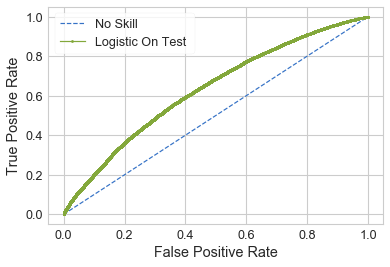

On Test Logistic ROC-AUC score is:  63.36792678822862


In [6]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test
telco_test['prob']=logreg.predict_proba(X_test)[:,1]
auc_curve(telco_test,y_test,'On Test ','Logistic ')


In [ ]:
On Test Logistic ROC-AUC score is:  63.23568883149694
On Test Logistic ROC-AUC score is:  63.364424326779975

In [11]:
#Random Forest

rf_clf =RandomForestClassifier(random_state=42, oob_score = True, n_jobs= -2, 
                              class_weight  = 'balanced', max_depth = 30,
                              n_estimators = 800, criterion = 'gini',
                              max_features = 'auto', verbose = 1)
rf_clf.fit(X_train, y_train)



[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-2)]: Done 428 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-2)]: Done 778 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-2)]: Done 800 out of 800 | elapsed:   36.8s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=800, n_jobs=-2, oob_score=True,
                       random_state=42, verbose=1, warm_start=False)

[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.3s
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:    0.7s
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:    1.5s
[Parallel(n_jobs=11)]: Done 800 out of 800 | elapsed:    1.5s finished


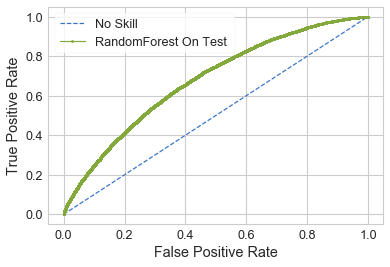

On Test RandomForest ROC-AUC score is:  67.9362592808266


In [12]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test
telco_test['prob']=rf_clf.predict_proba(X_test)[:,1]
auc_curve(telco_test,y_test,'On Test ','RandomForest ')

In [ ]:
On Test RandomForest ROC-AUC score is:  67.979692705267
On Test RandomForest ROC-AUC score is:  67.72893711901806

In [59]:
#Hyperparameter tunining for Random Forest:

def optimze(params,x,y):
    model=RandomForestClassifier(**params)
    
    #Intialize  K-Fold cv
    kf=KFold(n_splits=5)
    
    auc=[]
    
    for idx in kf.split(X=x,y=y):
        train_idx,test_idx=idx[0],idx[1]
        xtrain=x[train_idx]
        ytrain=y[train_idx]
        
        xtest=x[test_idx]
        ytest=y[test_idx]
        
        model.fit(xtrain,ytrain)
        
        preds=model.predict(xtest)
        
        fold_accuracy=roc_auc_score(ytest,preds)
        auc.append(fold_accuracy)
        
    return -1*np.mean(auc)


In [60]:
# Dividing the Train and Test Split
X=telo_df.drop(['churn'],axis=1)
y=telo_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

id_train=X_train['Customer_ID']
id_test=X_test['Customer_ID']

X_train=X_train.drop(['Customer_ID'],axis=1)
X_test=X_test.drop(['Customer_ID'],axis=1)

if __name__=="__main__":
    X=X_train.values
    y=y_train.values
    
    param_space={
        "max_depth":scope.int(hp.quniform("max_depth",6,34,2)),
        "n_estimators":scope.int(hp.quniform("n_estimators",100,1000,100)),
        "criterion": hp.choice("criterion",["gini","entropy"]),
        "max_features":hp.uniform("max_features",0,1)
    }
    
    optimzation_function=partial(
        optimze,
        x=X,
        y=y
        )
    
    trails=Trials()
    
    hopt=fmin(
    fn=optimzation_function,
    space=param_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=trails
    )
    
    
    print(hopt)
    

    
    


100%|█████████████████████████████████████████████| 5/5 [2:24:39<00:00, 1735.85s/trial, best loss: -0.6256139281549602]
{'criterion': 1, 'max_depth': 15.0, 'max_features': 0.7254922455784253, 'n_estimators': 724.0}


In [10]:
#XGBoost 
xgb_clf=xgb.XGBClassifier(n_jobs=-1,
                         max_depth=7,
                         eta=0.015,
                         min_child_weight=4,
                         reg_lambda=0.2,
                         alpha=0.5)

xgb_clf.fit(X_train,y_train)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.015, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0149999997, max_delta_step=0, max_depth=7,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.5,
              reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

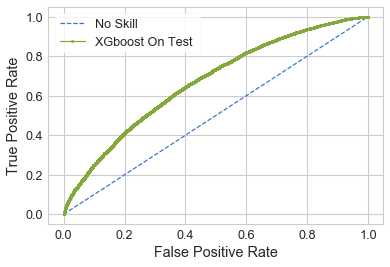

On Test XGboost ROC-AUC score is:  67.16299955707663


In [11]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test
telco_test['prob']=xgb_clf.predict_proba(X_test)[:,1]
auc_curve(telco_test,y_test,'On Test ','XGboost ')

In [34]:
#Light GBM

#Complete Model

lgb_clf = LGBMClassifier(
        nthread=4,
        boosting_type='dart',
        dart_subsample= 0.7939378386732971,
        #is_unbalance=True,
        n_estimators=2000,
        learning_rate=0.015,
        num_leaves=43,
        #gdbt_subsample=0.5184797122515694,
        colsample_bytree=0.9799583396125756,
        subsample=0.15812384729262252,
        max_depth=18,
        reg_alpha=0.08541990018975187,
        reg_lambda=0.36671588148988143,
        is_unbalance=False,
        min_split_gain=0.281363669132635,
        min_child_weight=48,
        silent=-1,
        verbose=-1,
        #scale_pos_weight=11
        )


lgb_clf.fit(X_train, y_train,eval_metric= 'auc', verbose= 50, early_stopping_rounds= 100)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Unknown parameter: dart_subsample


C:\Users\schilloji\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


LGBMClassifier(boosting_type='dart', class_weight=None,
               colsample_bytree=0.9799583396125756,
               dart_subsample=0.7939378386732971, importance_type='split',
               is_unbalance=False, learning_rate=0.015, max_depth=18,
               min_child_samples=20, min_child_weight=48,
               min_split_gain=0.281363669132635, n_estimators=2000, n_jobs=-1,
               nthread=4, num_leaves=43, objective=None, random_state=None,
               reg_alpha=0.08541990018975187, reg_lambda=0.36671588148988143,
               silent=-1, subsample=0.15812384729262252,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

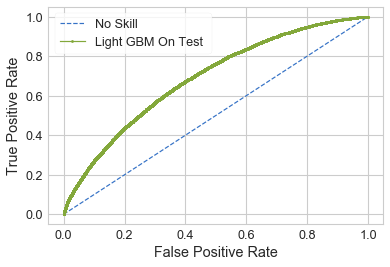

On Test Light GBM ROC-AUC score is:  69.04528762279142


In [31]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test
telco_test['prob']=lgb_clf.predict_proba(X_test,num_iteration=lgb_clf.best_iteration_)[:,1]
auc_curve(telco_test,y_test,'On Test ','Light GBM ')

In [33]:
conf_matr(telco_test,y_test,0.5)

[[9439 5735]
 [5175 9651]]
True Negatives:  9439
False Positives:  5735
False Negatives:  5175
True Positives:  9651
Accuracy: 0.6363333333333333
              precision    recall  f1-score   support

           0       0.65      0.62      0.63     15174
           1       0.63      0.65      0.64     14826

    accuracy                           0.64     30000
   macro avg       0.64      0.64      0.64     30000
weighted avg       0.64      0.64      0.64     30000



In [ ]:
On Test Light GBM ROC-AUC score is:  67.9012780305523
On Test Light GBM ROC-AUC score is:  68.14878259473474

In [13]:
#Creating LGB Dataset for CV

X_train_lgb=lgb.Dataset(X_train, label = y_train)

# Trials object to track progress

# File to save first results
OUT_FILE = 'gbm_trials.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

#Specifying the Parameters
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.0, 1.0)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.0, 1.0)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 1, 150, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_bin' : hp.quniform('max_bin', 800, 10000, 200),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'min_split_gain': hp.uniform('min_split_gain', 0.0, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 2, 100, 1),
    #'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.0, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}
      

In [15]:
nfolds = 5
def Objective_function(hyperparameters):
    # Keep the track record
    global ITERATION
    ITERATION += 1
    
    # We are calculating the n_estimators as per early stopping. Hence, it has to be updated after every iteration
    if "n_estimators" in hyperparameters:
        del hyperparameters["n_estimators"]
        
    # Extract the boosting type and subsample in proper format
    subsample = hyperparameters["boosting_type"].get("subsample", 1.0)
    hyperparameters["boosting_type"] = hyperparameters["boosting_type"]["boosting_type"]
    
    # Make sure all parameters are integers form
    for i in ['num_leaves','max_depth','min_child_weight','max_bin']:
        hyperparameters[i] = int(hyperparameters[i])
    
    start = timer()
    # Create the lightgbm model alog with cross validation
    model = lgb.cv(hyperparameters, 
                   X_train_lgb, 
                   num_boost_round=1000, 
                   metrics ="auc",
                   nfold = nfolds
              )
    
    # Run time of model
    run_time = timer() - start
    
    # best score 
    best_score = model["auc-mean"][-1]
    
    # loss
    loss = 1-best_score
    
    # Assigned n_estimators in hyperparameter as per the iterations in model
    hyperparameters["n_estimators"] = len(model["auc-mean"])
    
    # Write to the csv file ('a' means append)
    OUT_FILE = 'gbm_trials.csv'
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}
    
    


In [ ]:
# Algorithm
tpe_algorithm = tpe.suggest
# Record results
bayes_trials = Trials()

#Hyperparameter tuning process.
# Global variable
global  ITERATION
MAX_EVALS = 5

ITERATION = 0

# Run optimization
best = fmin(fn = Objective_function, space = space, algo = tpe.suggest, trials = bayes_trials,
            max_evals = MAX_EVALS)


[LightGBM] [Warning]                                                                                                   
Auto-choosing col-wise multi-threading, the overhead of testing was 0.028015 seconds.                                  
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]                                                                                                      
Total Bins 78348                                                                                                       
[LightGBM] [Info]                                                                                                      
Number of data points in the train set: 55999, number of used features: 129                                            
[LightGBM] [Warning]                                                                                                   
Auto-choosing col-wise multi-threading, the overhead of testing was 0.031960 seconds.                 

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

KeyboardInterrupt: 

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                    

KeyboardInterrupt: 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                     

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, be

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                                                                                                   
No further splits with positive gain, best gain: -inf                                                                  
[LightGBM] [Warning]                                                                                                   
Stopped training because there are no more leaves that meet the split requirements                                     
[LightGBM] [Warning]                    

In [189]:
# feature importance
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_Fe_train.columns
feature_importance_df["importance"] = lgb_clf.feature_importances_
    
final_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance.reset_index(inplace=True)
final_importance[0:50]



,feature,importance
0,change_mou,4004
1,eqpdays,3916
2,fe_mean_per_minute_charge,3488
3,fe_tot_mou_per_call,3158
4,fe_tot_revenue_per_call,3078
5,change_rev,2942
6,totmrc_Mean,2921
7,rev_Mean,2911
8,mou_Mean,2859
9,months,2776
